In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import os,sys
import io
from PIL import Image
import tensorflow as tf
from IPython.display import clear_output
import tensorflow_datasets as tfds
import tensorflow.io as tfio
from glob import glob
import time
import datetime
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import *
from keras.layers import *

%load_ext autoreload
%autoreload 2

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

#https://www.tensorflow.org/tutorials/images/segmentation

Tensorflow ver. 2.7.0


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

## Creating our Dataloader

In [25]:


dataset_path = "training/" 
training_data = "images/"
test_data = "test_set/"

# Image size that we are going to use
IMG_SIZE = 400
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 150 classes + `not labeled`
N_CLASSES = 2 #0: background, 1: road

In [26]:
TRAINSET_SIZE = len(glob(dataset_path + training_data + "*.png"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")
print(dataset_path + training_data + "*.png")


Groundtruth_SIZE = len(glob(dataset_path + "groundtruth/" + "*.png"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")
print(dataset_path + training_data + "*.png")


TESTSET_SIZE = len(glob(test_data +training_data+ "*.png"))
print(f"The Validation Dataset contains {TESTSET_SIZE} images.")


The Training Dataset contains 100 images.
training/images/*.png
The Training Dataset contains 100 images.
training/images/*.png
The Validation Dataset contains 50 images.


In [27]:
from helper_unet import parse_image

train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.png", seed=SEED)
type(train_dataset)
train_dataset = train_dataset.map(parse_image)
print(len(train_dataset))


test_dataset = tf.data.Dataset.list_files(test_data + training_data+"*.png", seed=SEED)
test_dataset = test_dataset.map(parse_image)
print(len(test_dataset))

100
50


In [28]:
# Division en train et val
train = train_dataset.take(60) 
val = train_dataset.skip(60)
print(val)
print(len(val))
print(len(train))

<SkipDataset shapes: {image: (None, None, 3), groundtruth: (None, None, 1)}, types: {image: tf.uint8, groundtruth: tf.uint8}>
40
60


## Applying some transformations to our dataset

In [29]:
from helper_unet import load_image_test, load_image_train

BATCH_SIZE = 32
BUFFER_SIZE = 1000
SEED = 42
dataset = {"train": train, "val": val}  # 1 dictionnaire avec 1 partie train, une partie validation pour le model.fit

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_train)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])


#-- Test Dataset --#
dataset_test = {"test": test_dataset}

dataset_test['test'] = dataset_test['test'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_test['test'] = dataset_test['test'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset_test['test'] = dataset_test['test'].repeat()
dataset_test['test'] = dataset_test['test'].batch(BATCH_SIZE)
dataset_test['test'] = dataset_test['test'].prefetch(buffer_size=AUTOTUNE)
print(dataset_test)

<PrefetchDataset shapes: ((None, 400, 400, 3), (None, 400, 400, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 400, 400, 3), (None, 400, 400, 1)), types: (tf.float32, tf.float32)>
{'test': <PrefetchDataset shapes: ((None, 400, 400, 3), (None, 400, 400, 1)), types: (tf.float32, tf.float32)>}


##  Visualizing the Dataset

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.92941177, shape=(), dtype=float32)


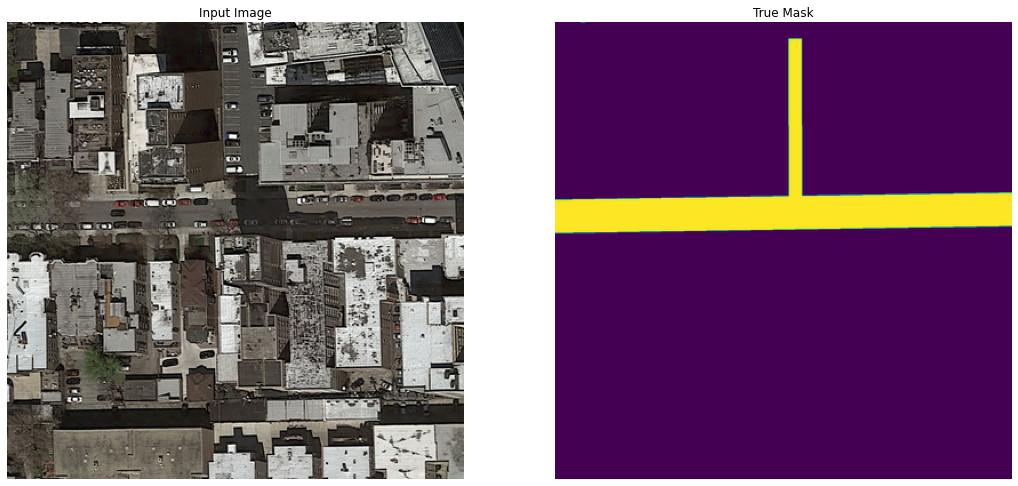

In [30]:
from helper_unet import display_sample

for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask
    #sample_image = sample_image[0][tf.newaxis, ...]
    print(tf.math.reduce_min(sample_image))
    print(tf.math.reduce_max(sample_image))
    print(tf.math.reduce_min(sample_mask))
    print(tf.math.reduce_max(sample_mask))
    display_sample([sample_image[0], sample_mask[0]])


## Developing the Model (UNet) Using Keras Functional API


In [ ]:
#https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
class UNET_(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.bn  = tf.keras.layers.BatchNormalization()
        self.maxpool= tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)
        
        #Encode
        #struct 1 
        self.conv1= tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, kernel_initializer = 'he_normal' , activation='relu', padding = 'same') 
        
        #struct 2
        self.conv2= tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, kernel_initializer = 'he_normal', activation='relu', padding = 'same') 

        #Struct 3
        self.conv3= tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, kernel_initializer = 'he_normal', activation='relu', padding = 'same') 

        #Struct 4
        self.conv4= tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, kernel_initializer = 'he_normal', activation='relu', padding = 'same') 

        #Struct 5
        self.conv5= tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, kernel_initializer = 'he_normal', activation='relu', padding = 'same') 

        #Decode
        # struct 6
        self.convT6=tf.keras.layers.Conv2DTranspose(filters= 128 , kernel_size = 3, padding = 'same')
        self.conv6= tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation='relu', padding = 'same') 

        # struct 7
        self.convT7=tf.keras.layers.Conv2DTranspose(filters= 64 , kernel_size = 3, padding = 'same')
        self.conv7= tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation='relu', padding = 'same') 

        # struct 8
        self.convT8=tf.keras.layers.Conv2DTranspose(filters= 32 , kernel_size = 3, padding = 'same')
        self.conv8= tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation='relu', padding = 'same') 

        # struct 9
        self.convT9=tf.keras.layers.Conv2DTranspose(filters= 16 , kernel_size = 3, padding = 'same')
        self.conv9= tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, activation='relu', padding = 'same') 

        #output

        self.output_ = tf.keras.layers.Conv2D(filters=1 ,kernel_size =1, activation = 'sigmoid')

    def call(self, inputs):
    #Encode
    # struct 1 
        c1 = self.conv1(inputs)
        c1 = self.bn(c1)
        c1 = self.conv1(c1)
        c1 = self.bn(c1)
        m1= self.maxpool(c1)

    # struct 2
        c2= self.conv2(m1)
        c2 = self.bn(c2)
        m2= self.maxpool(c2)

    # struct 3
        c3= self.conv3(m2)
        c3= self.bn(c3)
        m3= self.maxpool(c3)

    # struct 4
        c4= self.conv4(m3)
        c4= self.bn(c4)
        m4= self.maxpool(c4)
    
    # struct 5
        c5= self.conv5(m4)
        c5 = self.bn(c5)
    #Decode
    # struct 6
        c6 = self.convT6(c5)
        c6 = self.bn(c6)
        c6 =tf.keras.layers.concatenate([c6, c4])
        c6 = self.conv6(c6)

    # struct 7
        c7 = self.convT7(c6)
        c7= self.bn(c7)
        c7 =tf.keras.layers.concatenate([c7, c3])
        c7 = self.conv7(c7)
    
    # struct 8
        c8 = self.convT8(c7)
        c8= self.bn(c8)
        c8 =tf.keras.layers.concatenate([c8, c2])
        c8 = self.conv8(c8)

    # struct 9
        c9 = self.convT9(c8)
        c9= self.bn(c9)
        c9 =tf.keras.layers.concatenate([c9, c1])
        c9 = self.conv9(c9)
    
    #output 
        out= self.output_(c9)
        
        return out

In [ ]:
from helper_unet import create_mask, show_predictions
inputs = tf.keras.layers.Input((400,400,3))
outputs = tf.keras.layers.Input((400,400,3))

unet_model= UNET_()


unet_model.compile( loss  = tf.keras.losses.CategoricalCrossentropy(),
metrics   = tf.keras.metrics.CategoricalAccuracy(),
optimizer = tf.keras.optimizers.Adam())



# fit 
#unet_model.fit(x_train, y_train, batch_size=128, epochs=1)

In [22]:
PATH_TRAINING  = "training/" 
image_dir = PATH_TRAINING + "images/"
gt_dir = PATH_TRAINING + "groundtruth/"

def load_image(filename):
    return mpimg.imread(filename)

files = os.listdir(image_dir)
n = len(files)

print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]

print("Loading " + str(n) + " groundtruth images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

# Forcing x_traing and y_train to have a shape
# (num_img, img_width, img_height, num_channels) is necessary
x_train = np.asarray(imgs)
y_train = np.expand_dims(np.asarray(gt_imgs), axis=3)

print(np.max(x_train))
print(np.max(y_train))


Loading 100 images
Loading 100 groundtruth images
1.0
0.92941177


array([[[[0.39215687, 0.32941177, 0.2627451 ],
         [0.3529412 , 0.3019608 , 0.23529412],
         [0.28235295, 0.2627451 , 0.21960784],
         ...,
         [0.31764707, 0.29803923, 0.2509804 ],
         [0.30588236, 0.29411766, 0.24705882],
         [0.28627452, 0.2509804 , 0.21960784]],

        [[0.40392157, 0.34117648, 0.2784314 ],
         [0.34901962, 0.29803923, 0.24705882],
         [0.32941177, 0.3019608 , 0.25882354],
         ...,
         [0.31764707, 0.29803923, 0.27450982],
         [0.33333334, 0.30980393, 0.28627452],
         [0.41960785, 0.3882353 , 0.34509805]],

        [[0.34117648, 0.3254902 , 0.27450982],
         [0.34901962, 0.3019608 , 0.2509804 ],
         [0.39607844, 0.3372549 , 0.2784314 ],
         ...,
         [0.16470589, 0.16470589, 0.17254902],
         [0.21568628, 0.20392157, 0.21176471],
         [0.2901961 , 0.27450982, 0.28235295]],

        ...,

        [[0.3019608 , 0.27058825, 0.23137255],
         [0.30588236, 0.27450982, 0.23137255]

In [31]:
#2eme essai
filter= 32

def encode(inputs,filter_n, max_pooling=True):
    filter= 16
    c1= tf.keras.layers.Conv2D(filters = filter*filter_n, kernel_size = 3, kernel_initializer = 'he_normal' , activation='relu', padding = 'same') (inputs)
    c2= tf.keras.layers.Conv2D(filters = filter*filter_n, kernel_size = 3, kernel_initializer = 'he_normal' , activation='relu', padding = 'same') (c1)
    b1= tf.keras.layers.BatchNormalization()(c2)
    if max_pooling :
        m1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(b1)
    else :
        m1=0
    return b1, m1


def decode(inputs_1, inputs_2, filter_n): 
    filter = 16
    ct1 = tf.keras.layers.Conv2DTranspose(filters= filter*filter_n , kernel_size = 3,strides = (2,2), padding = 'same')(inputs_1)
    ccat1= tf.keras.layers.concatenate([ct1, inputs_2])
    c1= tf.keras.layers.Conv2D(filters = filter*filter_n, kernel_size = 3, kernel_initializer = 'he_normal' , activation='relu', padding = 'same') (ccat1)
    c2= tf.keras.layers.Conv2D(filters = filter*filter_n, kernel_size = 3, kernel_initializer = 'he_normal' , activation='relu', padding = 'same') (c1)
    b1= tf.keras.layers.BatchNormalization()(c2)
    return b1


def unet_model(input_size = (400,400,3)):
    inputs = Input(input_size)

    #encode
    b1, m1 = encode(inputs,1,  max_pooling = True)
    b2, m2 = encode(m1, 2,  max_pooling = True)
    b3, m3 = encode(m2, 4,  max_pooling = True)
    b4 , m4 = encode(m3, 8, max_pooling = True)
    b5, m5 = encode(m4,16, max_pooling = False)

    #decode
    d1= decode(b5,b4, 8)
    d2 = decode(d1,b3, 4)
    d3 = decode(d2,b2, 2)
    d4 = decode(d3,b1, 1)

    #output
    output_layer= tf.keras.layers.Conv2D(filters=1 ,kernel_size =1, activation = 'sigmoid')(d4)
    
    model = Model(inputs = [inputs], outputs = [output_layer])
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt,loss = 'binary_crossentropy', metrics=['Precision', 'Recall'])

    model.summary()
    return model

model = unet_model()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 400, 400, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 400, 400, 16  2320        ['conv2d_38[0][0]']              
                                )                                                           

In [13]:
EPOCHS = 4
TRAINSET_SIZE= 60
VALSET_SIZE= 40
BATCH_SIZE = 32
STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE




class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        for image, mask in dataset['val'].take(1):
            sample_image, sample_mask = image, mask
            one_img_batch = sample_image[0][tf.newaxis, ...]
            inference = model.predict(one_img_batch)
            pred_mask = create_mask(inference)
            display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])

        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

#try with sample weights

model_history = model.fit(x_train, y_train, epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_split=0.4,
    ) #callbacks=[DisplayCallback()]



Epoch 1/4
1/1 [==============================] - 127s 127s/step - loss: 0.8010 - precision: 0.2118 - recall: 0.4774 - val_loss: 0.7409 - val_precision: 0.2311 - val_recall: 0.8386
Epoch 2/4
1/1 [==============================] - 117s 117s/step - loss: 0.7653 - precision: 0.2317 - recall: 0.5361 - val_loss: 0.7146 - val_precision: 0.2314 - val_recall: 0.6965
Epoch 3/4
1/1 [==============================] - 162s 162s/step - loss: 0.7400 - precision: 0.2488 - recall: 0.5905 - val_loss: 0.6821 - val_precision: 0.2298 - val_recall: 0.4122
Epoch 4/4
1/1 [==============================] - 126s 126s/step - loss: 0.7209 - precision: 0.2644 - recall: 0.6410 - val_loss: 0.6561 - val_precision: 0.2299 - val_recall: 0.3603


In [10]:

IMG_SIZE = 400
NUM_CHANNELS = 3
NUM_FILTER = 32
FILTER_SIZE = 3


def activation(data, leaky):
    """Choose the activation function"""
    if leaky:
        return tf.keras.layers.LeakyReLU()(data)
    else:
        return tf.keras.layers.ReLU()(data)


def conv_block(data, n_filter, filter_size, leaky):
    """Performs two convolutions with batch normalizing and activation function at each layer"""
    conv1_inner = tf.keras.layers.Conv2D(n_filter,filter_size,padding='same',kernel_initializer='he_normal')(data)
    conv1_inner = tf.keras.layers.BatchNormalization()(conv1_inner)
    x1 = activation(conv1_inner, leaky)

    conv2_inner = tf.keras.layers.Conv2D(n_filter,filter_size,padding='same',kernel_initializer='he_normal')(x1)
    conv2_inner = tf.keras.layers.BatchNormalization()(conv2_inner)
    x2 = activation(conv2_inner, leaky)
    return x2


def down_sample(data, n_filter, filter_size, leaky, dropout):
    conv = conv_block(data, n_filter, filter_size, leaky)
    pool = tf.keras.layers.MaxPool2D((2, 2))(conv)
    if dropout is not None:
        pool = tf.keras.layers.Dropout(dropout)(pool)
    return conv, pool


def up_sample(data, n_filter, filter_size, leaky, dropout):
    conv = conv_block(data, n_filter, filter_size, leaky)
    up = tf.keras.layers.Conv2DTranspose(n_filter,filter_size,(2, 2),padding='same',kernel_initializer='he_normal')(conv)
    if dropout is not None:
        up = tf.keras.layers.Dropout(dropout)(up)
    return up


def unet(data, n_filter, filter_size, leaky, dropout):
    """Construct the U-Net architecture"""

    conv1, pool1 = down_sample(data, n_filter, filter_size, leaky, dropout)
    conv2, pool2 = down_sample(pool1, n_filter * 2, filter_size, leaky, dropout)
    conv3, pool3 = down_sample(pool2, n_filter * 4, filter_size, leaky, dropout)
    conv4, pool4 = down_sample(pool3, n_filter * 8, filter_size, leaky, dropout)
    conv5 = conv_block(pool4, n_filter * 16, filter_size, leaky)

    up6 = tf.keras.layers.Conv2DTranspose(n_filter * 8,filter_size,(2, 2),padding='same',kernel_initializer='he_normal')(conv5)
    up6 = tf.keras.layers.concatenate([up6, conv4], axis=3)
    up7 = up_sample(up6, n_filter * 4, filter_size, leaky, dropout)
    up7 = tf.keras.layers.concatenate([up7, conv3], axis=3)
    up8 = up_sample(up7, n_filter * 2, filter_size, leaky, dropout)
    up8 = tf.keras.layers.concatenate([up8, conv2], axis=3)
    up9 = up_sample(up8, n_filter, filter_size, leaky, dropout)
    up9 = tf.keras.layers.concatenate([up9, conv1], axis=3)

    up9 = conv_block(up9, n_filter, filter_size, leaky)
    output = tf.keras.layers.Conv2D(filters=1, kernel_size=1, activation='sigmoid')(up9)

    return output


def unet_model(img_size, n_channel, n_filter, filter_size, leaky=False, dropout=None):
    """Construct the U-Net model"""
    inputs = tf.keras.layers.Input((img_size, img_size, n_channel))
    outputs = unet(inputs, n_filter, filter_size, leaky, dropout)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['Precision', 'Recall'])
    model.summary()
    return model



model = unet_model(IMG_SIZE, NUM_CHANNELS, NUM_FILTER, FILTER_SIZE, leaky=True, dropout=0.5)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 400, 400, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 400, 400, 32  128        ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

(1, 400, 400, 1)
(array([0.        , 0.92941177], dtype=float32), array([154409,   5591]))


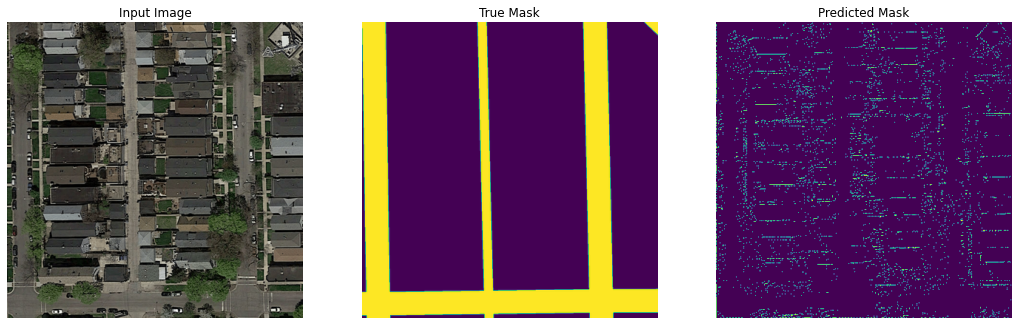

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.92941177, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.92941177, shape=(), dtype=float32)


In [35]:
from helper_unet import create_mask, show_predictions, display_sample


for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask
    one_img_batch = sample_image[0][tf.newaxis, ...]
    pred_mask = model.predict(one_img_batch)

    pred_mask = create_mask(pred_mask)
    print(pred_mask.shape)
    #print(pred_mask.min())
    #print(pred_mask.max())
    print(np.unique(pred_mask, return_counts=True))
    display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])


    print(tf.math.reduce_min(sample_image))
    print(tf.math.reduce_max(sample_image))
    print(tf.math.reduce_min(sample_mask))
    print(tf.math.reduce_max(sample_mask))
    print(tf.math.reduce_min(pred_mask))
    print(tf.math.reduce_max(pred_mask))




In [36]:
EPOCHS = 4
TRAINSET_SIZE= 60
VALSET_SIZE= 40
BATCH_SIZE = 32
STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE




class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        for image, mask in dataset['val'].take(1):
            sample_image, sample_mask = image, mask
            one_img_batch = sample_image[0][tf.newaxis, ...]
            inference = model.predict(one_img_batch)
            pred_mask = create_mask(inference)
            display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])

        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

#try with sample weights

model_history = model.fit(dataset['train'], epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data = dataset['val'],
    ) #callbacks=[DisplayCallback()]




Epoch 1/4
1/1 [==============================] - 99s 99s/step - loss: 0.7807 - precision: 0.2710 - recall: 0.6489 - val_loss: 0.6617 - val_precision: 0.1657 - val_recall: 0.0230
Epoch 2/4
1/1 [==============================] - 54s 54s/step - loss: 0.7563 - precision: 0.2572 - recall: 0.6513 - val_loss: 0.6573 - val_precision: 0.1671 - val_recall: 0.0335
Epoch 3/4
1/1 [==============================] - 62s 62s/step - loss: 0.7270 - precision: 0.2938 - recall: 0.6752 - val_loss: 0.6562 - val_precision: 0.1813 - val_recall: 0.0838
Epoch 4/4
1/1 [==============================] - 58s 58s/step - loss: 0.7149 - precision: 0.2848 - recall: 0.6672 - val_loss: 0.6514 - val_precision: 0.2056 - val_recall: 0.1351


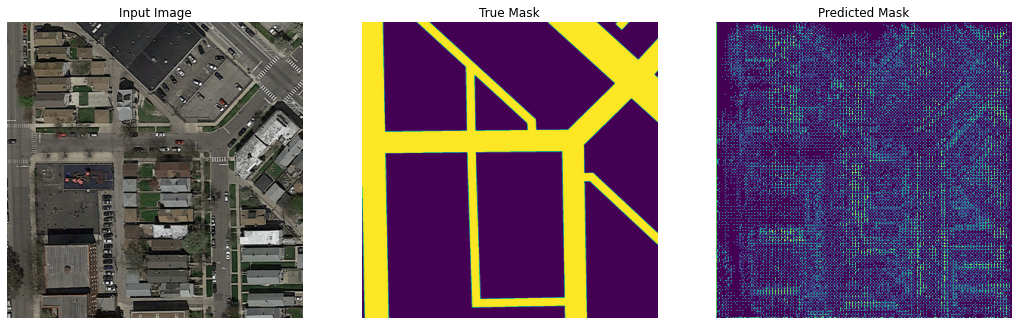

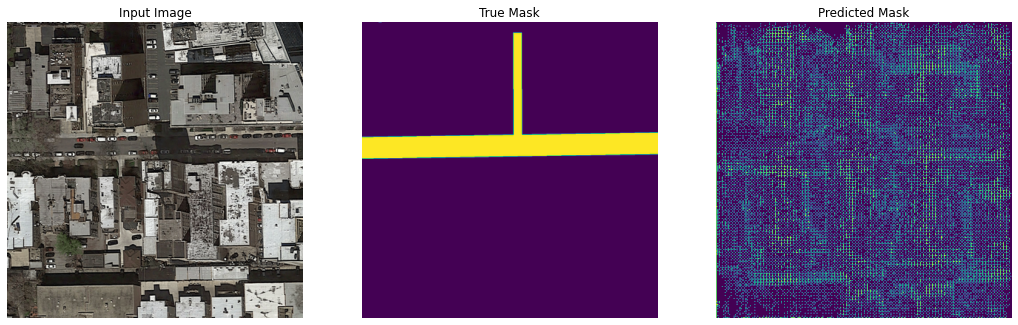

In [37]:
for image, mask in dataset['val'].take(2):
    sample_image, sample_mask = image, mask
    one_img_batch = sample_image[0][tf.newaxis, ...]
    inference = model.predict(one_img_batch)
    pred_mask = create_mask(inference)
    display_sample([sample_image[0], sample_mask[0], pred_mask[0]])

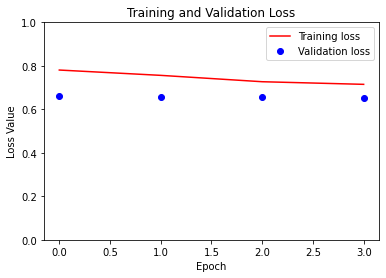

In [38]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')